# Understanding the binary JSSP representation

This representation was presented by Ryohei Nakano and Takeshi Yamada in the paper (Nakano & Yamada, 1991).

3 x 3 JSSP problem:

j1 2(1), 3(5), 1(2) \
j2 1(3), 2(3), 3(5) \
j3 1(2), 3(2), 2(4) 

We have nm(n-1)/2 binary strings

In [603]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import pdb

In [604]:
# Defining technological sequences for each job
tech_seq = np.array([[2, 3, 1], 
                     [1, 2, 3], 
                     [1, 3, 2]], dtype=int)

In [605]:
# Operation matrix - elements are time, columns are machines, rows are jobs
operation_mat = np.array([[2, 1, 5], 
                          [3, 3, 5], 
                          [2, 4, 2]], dtype=int)


In [606]:
n_jobs = 3
n_machines = 3
bit_strings = np.random.randint(0, 2, (int(n_jobs*(n_jobs-1)/2), n_machines))

Applying local harmonization

In [607]:
bit_strings

array([[0, 0, 0],
       [0, 1, 1],
       [1, 0, 1]])

In [608]:
np.arange(1, n_jobs+1, dtype=int)

array([1, 2, 3])

In [609]:
def local_harmonization(cur_priority_mat : np.ndarray):
    # Copy the priority matrix for further processing
    temp_machine_matrix = copy.deepcopy(cur_priority_mat)
    n_jobs = cur_priority_mat.shape[0]
    # prepare array for holding the machine order
    machine_order = np.zeros(n_jobs)
    job_tracker = np.arange(1, n_jobs+1, dtype=int)
    for cur_jobnumber in range(1, n_jobs+1):
        # For each job in the machine sequence - eliminate the job with least priority
        # Sum each row to get a vector where the smallest element represent least priority
        current_sum = np.sum(temp_machine_matrix, axis=1)
        # The indexes of the least priority jobs
        temp_indexes = np.arange(0, temp_machine_matrix.shape[0])[np.min(current_sum) == current_sum]
        # Picking a random index
        cur_choise = np.random.choice(temp_indexes)
        # extracting current bit string based on choice
        cur_bitstring = temp_machine_matrix[cur_choise] 
        for i, k in enumerate(cur_bitstring):
            # For each bit check if it is value 1
            if k == 1:
                # Make the swap
                temp_machine_matrix[i, cur_choise] = 1
                temp_machine_matrix[cur_choise, i] = 0
        # The least priorized job has now 0 outgoing arcs

        # creating mask to remove the least priorized job for next iteration
        bool_mask = np.ones(temp_machine_matrix.shape[0], dtype=bool)
        bool_mask[cur_choise] = False
        # Remove row and column
        temp_machine_matrix = temp_machine_matrix[bool_mask, :][:, bool_mask]
        # Update machine sequence by finding the original index of the chosen index
        job_number = job_tracker[cur_choise]
        job_tracker = job_tracker[bool_mask]

        # The removed job is appended to the reversed machine sequence array
        machine_order[-cur_jobnumber] = job_number

    return machine_order

In [610]:
# We first need to create the priority matrix of each machine
pair_mapping = {0:[0, 1], 1:[1, 2], 2:[0, 2]}
machine_list = []
for m in range(n_machines):
    cur_priority_mat = np.zeros((3,3))
    for i, job_pair in enumerate(bit_strings):
        cur_priority_mat[pair_mapping[i][0]][pair_mapping[i][1]] = job_pair[m]
        cur_priority_mat[pair_mapping[i][1]][pair_mapping[i][0]] = 0 if job_pair[m] == 1 else 1 

    print(f"Converting the following priority matrix as M{m}:")
    print(cur_priority_mat)
    converted_list = local_harmonization(cur_priority_mat)
    print("Result:")
    print(converted_list)
    machine_list.append(converted_list)

Converting the following priority matrix as M0:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Result:
[1. 3. 2.]
Converting the following priority matrix as M1:
[[0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]]
Result:
[2. 3. 1.]
Converting the following priority matrix as M2:
[[0. 0. 1.]
 [1. 0. 1.]
 [0. 0. 0.]]
Result:
[2. 1. 3.]


In [611]:
complete_machine_ordering = np.concatenate(machine_list, axis=0).reshape(n_machines, n_jobs).astype(int)
complete_machine_ordering

array([[1, 3, 2],
       [2, 3, 1],
       [2, 1, 3]])

In [612]:
complete_machine_ordering

array([[1, 3, 2],
       [2, 3, 1],
       [2, 1, 3]])

In [613]:
for i in complete_machine_ordering:
    print(i)

[1 3 2]
[2 3 1]
[2 1 3]


Currently there is still a posibility of global inconsistecies between the machine orderings and the technical sequences.
This is demonstrated by the following gnatt diagram:

In [614]:
class Operation:
    def __init__(self, duration : int, machine : object, job : object) -> None:
        self.duration = duration
        self.machine = machine
        self.job = job

class Job:
    def __init__(self, id : int, n_operations : int) -> None:
        self.id = id
        self.operation_counter = 0
        self.free_at_timestep = 0
        self.operation_list = np.empty(n_operations, dtype=Operation)

    def set_operation(self, operation : Operation, m : int):
        self.operation_list[m] = operation

    def get_next_operation(self):
        return self.operation_list[self.operation_counter]

    def increment_counter(self):
        self.operation_counter += 1

    def is_scheduled(self):
        return self.operation_counter >= len(self.operation_list)

class Machine:
    def __init__(self, id : int, machine_ordering : np.ndarray) -> None:
        self.id = id
        self.operation_counter = 0
        self.machine_ordering = machine_ordering
        self.free_at = 0

    def get_next_operation(self):
        return self.machine_ordering[self.operation_counter]

    def permute_order(self, target):
        print("Before permutation: " + str(self.machine_ordering))
        temp = self.machine_ordering[self.operation_counter]
        self.machine_ordering[self.operation_counter] = self.machine_ordering[target]
        
        for i in range(self.operation_counter+1, target):
            next_temp = self.machine_ordering[i]
            self.machine_ordering[i] = temp
            temp = next_temp

        self.machine_ordering[target] = temp
        print("After permutation: " + str(self.machine_ordering))

    def increment_counter(self):
        self.operation_counter += 1


class Schedule:
    def __init__(self, jobs, machines):
        self.jobs = jobs
        self.machines = machines
        self.time_step = 0
        self.gnatt_list = []
        self.total_operations = len(jobs) * len(machines)
        print(self.total_operations)

    def schedule_operations(self):
        while True:
            for job in self.jobs:
                # For each job, check if it can be scheduled
                # Is it locked?
                if job.free_at_timestep <= self.time_step and not job.is_scheduled():
                    # The job is free for scheduling
                    # Check if the next operation of job matches the next operation of the machine
                    next_operation = job.get_next_operation()
                    cur_machine = next_operation.machine
                    if cur_machine.free_at <= self.time_step:
                        if job.id == cur_machine.get_next_operation():
                            # The next job matches for the machine priority list
                            # Next the job is scheduled on the coresponding machine
                            print("Appending original")
                            self.gnatt_list.append({
                                                "Task" : f"M{cur_machine.id}", 
                                                "start_time" : self.time_step, 
                                                "stop_time" : self.time_step + next_operation.duration,
                                                "operation" : f"O_{job.id},{cur_machine.id}"})                   
                        else:
                            print("Trying to correct")
                            print(cur_machine.machine_ordering)
                            print(cur_machine.machine_ordering[cur_machine.operation_counter:])
                            print("cur_job" + str(job.id))
                            # There is a global conflict
                            # find the operation that can be scheduled for this job
                            for i, j in enumerate(cur_machine.machine_ordering[cur_machine.operation_counter:]):
                                if j ==  job.id:
                                    # Permute machine priority
                                    cur_machine.permute_order(cur_machine.operation_counter + i)
                                    print("Appending corrected")
                                    self.gnatt_list.append({
                                                "Task" : f"M{cur_machine.id}", 
                                                "start_time" : self.time_step, 
                                                "stop_time" : self.time_step + next_operation.duration,
                                                "operation" : f"O_{job.id},{cur_machine.id}"})
                        
                        job.free_at_timestep = self.time_step + next_operation.duration
                        cur_machine.free_at = self.time_step + next_operation.duration
                        cur_machine.increment_counter()
                        job.increment_counter()
                        self.total_operations -= 1
                        print(self.total_operations)

            if self.total_operations <= 0:
                break
            
            self.time_step += 1
            

                    


# Create job and machine objects
jobs = []
machines = []
for i, operations in enumerate(tech_seq):
    jobs.append(Job(i+1, len(operations)))

for m, machine_ordering in enumerate(complete_machine_ordering):
    machines.append(Machine(m+1, machine_ordering))

for j, cur_tech_seq in enumerate(tech_seq):
    for place, m in enumerate(cur_tech_seq):
        cur_operation = Operation(operation_mat[i-1, m-1], machines[m-1], jobs[j-1])
        jobs[j-1].set_operation(cur_operation, place)

cur_schedule = Schedule(jobs, machines)
cur_schedule.schedule_operations()
cur_schedule.gnatt_list


9
Appending original
8
Trying to correct
[2 3 1]
[2 3 1]
cur_job3
Before permutation: [2 3 1]
After permutation: [3 2 1]
Appending corrected
7
Trying to correct
[3 2 1]
[2 1]
cur_job1
Before permutation: [3 2 1]
After permutation: [3 1 2]
Appending corrected
6
Trying to correct
[1 3 2]
[3 2]
cur_job2
Before permutation: [1 3 2]
After permutation: [1 2 3]
Appending corrected
5
Trying to correct
[2 1 3]
[2 1 3]
cur_job3
Before permutation: [2 1 3]
After permutation: [3 2 1]
Appending corrected
4
Trying to correct
[3 2 1]
[2 1]
cur_job1
Before permutation: [3 2 1]
After permutation: [3 1 2]
Appending corrected
3
Appending original
2
Appending original
1
Appending original
0


[{'Task': 'M1', 'start_time': 0, 'stop_time': 3, 'operation': 'O_1,1'},
 {'Task': 'M2', 'start_time': 0, 'stop_time': 3, 'operation': 'O_3,2'},
 {'Task': 'M2', 'start_time': 3, 'stop_time': 6, 'operation': 'O_1,2'},
 {'Task': 'M1', 'start_time': 3, 'stop_time': 6, 'operation': 'O_2,1'},
 {'Task': 'M3', 'start_time': 3, 'stop_time': 8, 'operation': 'O_3,3'},
 {'Task': 'M3', 'start_time': 8, 'stop_time': 13, 'operation': 'O_1,3'},
 {'Task': 'M1', 'start_time': 8, 'stop_time': 11, 'operation': 'O_3,1'},
 {'Task': 'M3', 'start_time': 13, 'stop_time': 18, 'operation': 'O_2,3'},
 {'Task': 'M2', 'start_time': 18, 'stop_time': 21, 'operation': 'O_2,2'}]

In [615]:
df = pd.DataFrame(cur_schedule.gnatt_list)
df

,Task,start_time,stop_time,operation
0,M1,0,3,"O_1,1"
1,M2,0,3,"O_3,2"
2,M2,3,6,"O_1,2"
3,M1,3,6,"O_2,1"
4,M3,3,8,"O_3,3"
5,M3,8,13,"O_1,3"
6,M1,8,11,"O_3,1"
7,M3,13,18,"O_2,3"
8,M2,18,21,"O_2,2"


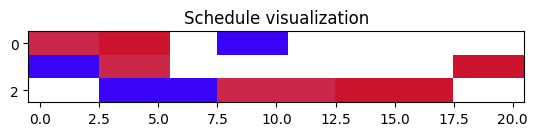

In [616]:
start_time = 0
stop_time = df["stop_time"].max()
n_rows = df["Task"].unique().shape[0]
color_dict = {i : np.random.randint(0, 256, 3) for i in range(1, n_rows+1)}
image = np.ones((n_rows, int(stop_time), 3), dtype=int) * 255
for operation in cur_schedule.gnatt_list:
    cur_job = int(operation["operation"][2])
    machine_number = int(operation["Task"][-1])-1
    image[machine_number][int(operation["start_time"]) : int(operation["stop_time"])][:] = color_dict[cur_job]

plt.title("Schedule visualization")
plt.imshow(image)
plt.show()

As can bee seen above, the resultingschedule is not active

### References

Nakano, R., & Yamada, T. (1991). Conventional Genetic Algorithm for Job Shop Problems. 91, 474–479.
